## Angle vs. Time Plot of Pendulums

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

#### Load angles from file

The experiment is conducted with pendulums modeled with a lock hanging on a thin string. Experiment is repeated with different rest lengths of the string. However, the actual length of the pendulum may be longer due to the stretch of the string and the size of the lock.

A one-minute video of the pendulum is recorded and the motion of the pendulum is tracked using OpenCV. The CSV files with the time and the UV coordinates of the pendulum relative to a rectangular frame is stored under `csv/uvt-{length}.csv`. The width of the frame is 0.98m and the height of the frame is 1.36m. One end of the string is tied on the middle of the top of the frame.

In [2]:
LENGTHS = [20, 30, 40, 50, 60, 70, 80]
WIDTH, HEIGHT = 0.98, 1.36

data = {}
for length in LENGTHS:
    # load data from file
    with open(f"csv/uvt-{length}.csv", 'r') as fp:
        lines = fp.read().strip().replace('\r', '').split('\n')
        content = [list(map(float, line.split(','))) for line in lines]
        content = np.array(content, dtype=np.float64)
    # get length and angle
    t = content[:, 0]
    x = WIDTH * (content[:, 1] - 0.5)
    y = HEIGHT * content[:, 2]
    r = np.hypot(x, y)
    a = np.arctan2(x, y)
    # remove data points with abnormal lengths
    # possibly due to tracking error
    medr = np.median(r)
    i = np.where((0.85 * r < medr) & (medr < 1.15 * r))
    t, x, y, r, a = t[i], x[i], y[i], r[i], a[i]
    if False:
        plt.plot(t, r)
        plt.show()
    # save processed data
    l = np.median(r)
    l_uncert = max(abs(r-l))
    print("Length: {:.2f} m ± {:.2f} m".format(l, l_uncert))
    data[length] = {
        't': t,
        'l': l,
        'l_uncert': l_uncert,
        'a': a-np.mean(a)  # angle measuring shift
    }

Length: 0.28 m ± 0.03 m
Length: 0.38 m ± 0.05 m
Length: 0.48 m ± 0.04 m
Length: 0.57 m ± 0.03 m
Length: 0.67 m ± 0.03 m
Length: 0.77 m ± 0.06 m
Length: 0.88 m ± 0.03 m


Plot a random angle-time graph to see if it looks right

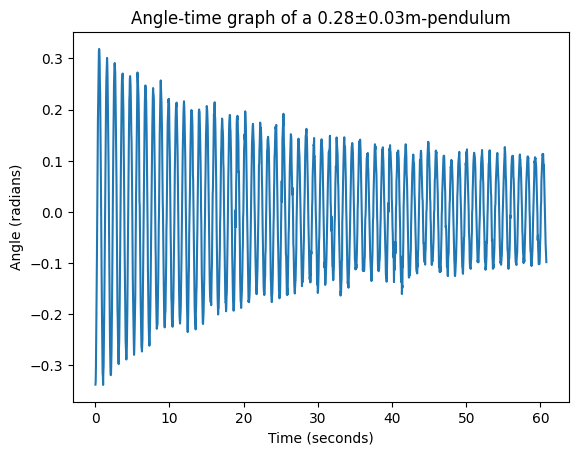

In [3]:
sample_data = data[20]
plt.clf()
plt.title("Angle-time graph of a {:.2f}±{:.2f}m-pendulum".format(
    sample_data['l'], sample_data['l_uncert']))
plt.xlabel("Time (seconds)")
plt.ylabel("Angle (radians)")
plt.plot(sample_data['t'], sample_data['a'])
plt.show()

#### Fit the data

Linearly damped harmonic oscillator model

$\theta(t) = \theta_0 \operatorname{e}^{-t/\tau} \cos\left(2\pi\frac{t}{T}+\phi_0\right)$

C:\Users\harry\AppData\Local\Temp\ipykernel_4320\3105063164.py:2: RuntimeWarning: overflow encountered in exp
  return a0 * np.exp(-t/tau) * np.cos(2.*np.pi*t/period + phase)


20 [ 0.28452712  1.03090916  2.64803593 48.10040656]


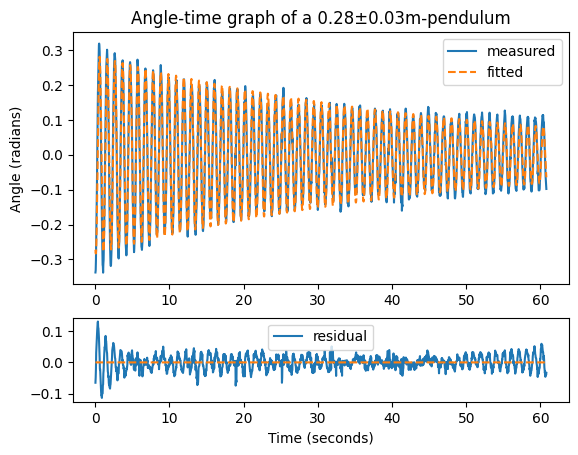

30 [-0.31704488  1.22452078  1.48558649 70.23162454]


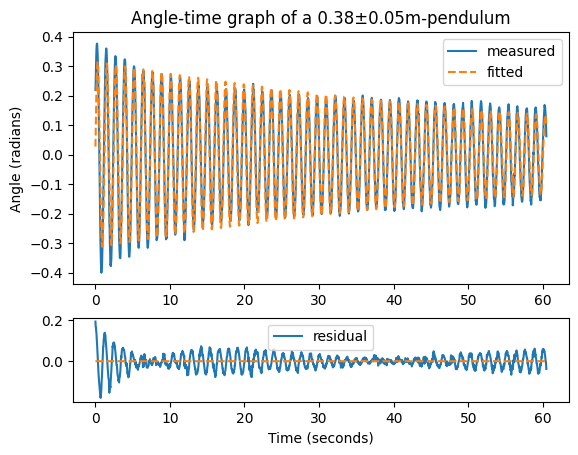

40 [ 0.40685706  1.38341764  1.06091108 88.80458134]


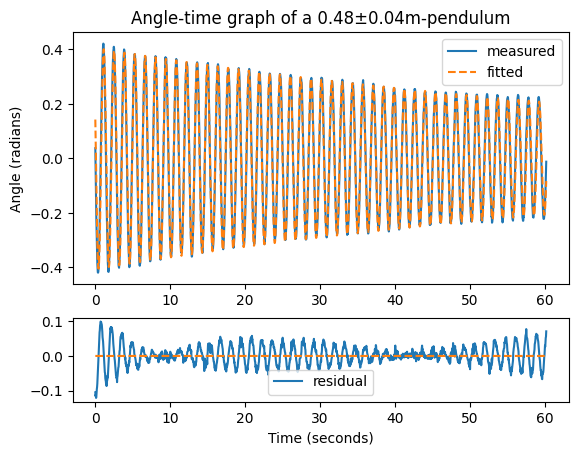

50 [  0.47197709   1.52486698   1.47275926 106.72199801]


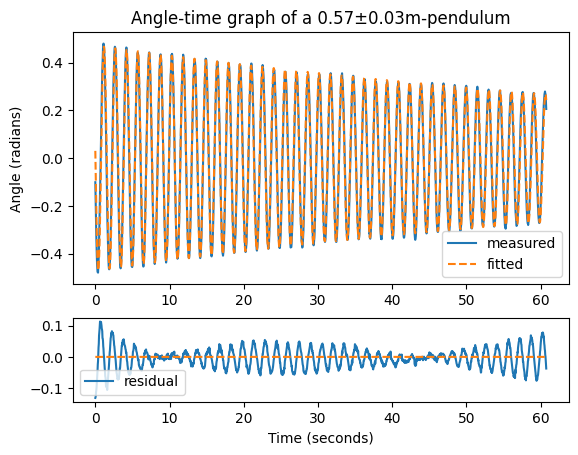

60 [  0.43191806   1.65319969   1.27390777 121.67327956]


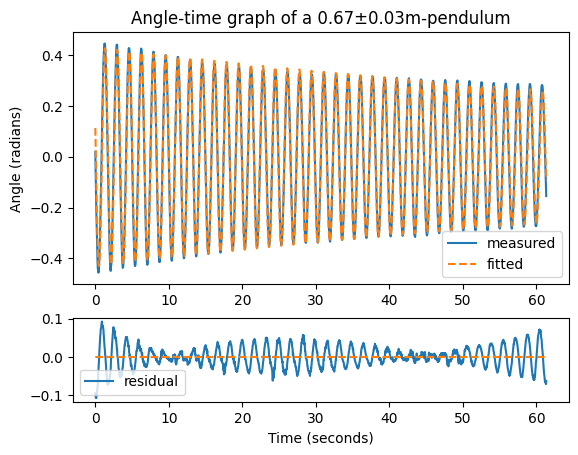

70 [ -0.47078142   1.78147869   1.54956386 119.44879366]


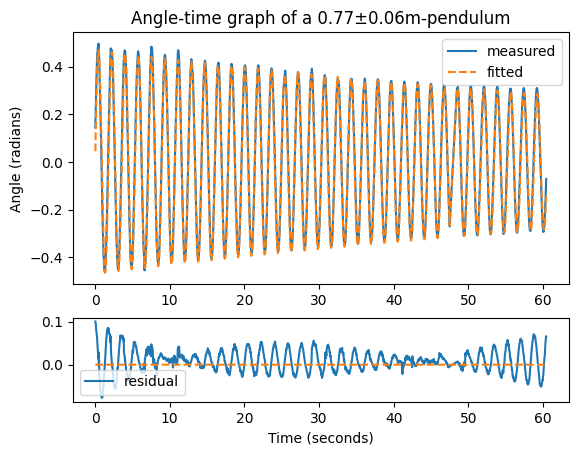

80 [  0.46487499   1.89527551   1.03669946 144.83970908]


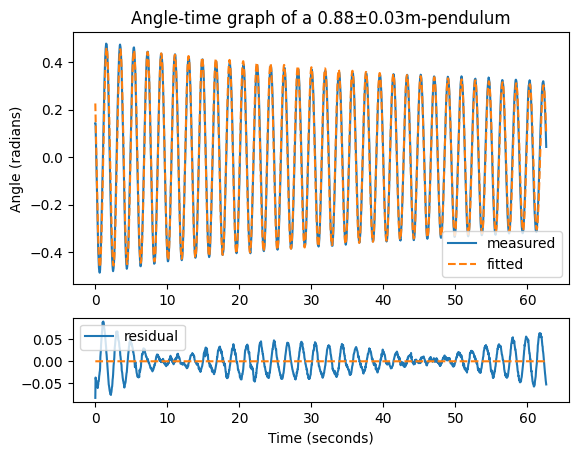

In [4]:
def damped_harmonic(t, a0, period, phase, tau):
    return a0 * np.exp(-t/tau) * np.cos(2.*np.pi*t/period + phase)

def fit_data(t, a):
    init_guess = (1, 1, 1, 1)
    popt, popv = scipy.optimize.curve_fit(
        damped_harmonic, t, a,
        p0=init_guess)
    return popt

def plot_angle_time_graph(l, l_uncert, t, a, params):
    a_pred = damped_harmonic(t, *params)
    residual = a - a_pred

    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

    ax1.set_title("Angle-time graph of a {:.2f}±{:.2f}m-pendulum".format(l, l_uncert))
    ax2.set_xlabel("Time (seconds)")
    ax1.set_ylabel("Angle (radians)")

    ax1.plot(t, a, '-')
    ax1.plot(t, a_pred, '--')
    ax1.legend(['measured', 'fitted'])

    ax2.plot(t, residual)
    ax2.legend(["residual"])
    ax2.plot(t, np.zeros(len(t)), '--')
    plt.show()

for length in LENGTHS:
    sample_data = data[length]
    t, a = sample_data['t'], sample_data['a']
    params = fit_data(t, a)
    print(length, params)
    plot_angle_time_graph(
        sample_data['l'], sample_data['l_uncert'],
        t, a, params)
    # break
